<a href="https://colab.research.google.com/github/ceos-seo/odc-colab/blob/master/notebooks/02.02.Colab_Cloud_Statistics_S2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentinel-2 Cloud Statistics
This notebook explores sample Sentinel-2 data from Google Earth Engine which has been indexed to work with the Open Data Cube. The data is used to calculate cloud statistics for selected regions. This is valuable information for performing analysis. For example, if there are extensive clouds for a season it may significantly impact the mosaic product or index values. Another example is that a user may want to find a single date when there are few clouds to assess land features.

## Instructions for Execution
It is suggested that users first execute the notebook "as is" to successfully complete the Google authorizations and view sample results. Then, users should look for the "MODIFY HERE" labels at the top of several code blocks to identify code that can be modified. These include:<br>
<br>#1 - Define the center and size of the analysis region
<br>#2 - Select a time range for the data analysis
<br>#3 - Select a time slice from the coverage summary table to view 
<br><br>
Once the full notebook has been run, users can run individual code blocks using "Shift-Return" or run segments of the code using the Runtime menu. Users do not have to go thru the Google authorization steps for additional execution cycles. 

In [1]:
!wget -nc https://raw.githubusercontent.com/ceos-seo/odc-colab/master/odc_colab.py
from odc_colab import odc_colab_init
odc_colab_init(install_odc_gee=True)

In [2]:
from odc_colab import populate_db
populate_db()

In [3]:
# Load Data Cube Configuration
from odc_gee import earthengine
dc = earthengine.Datacube(app='Cloud_Statistics')

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

# Import Data Cube Utilities
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_rgb import rgb

# Import Common Utilities
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Select a Product and Platform
# This data is indexed from Google Earth Engine data sources

product = "s2_google"
platform = "Sentinel-2A"

In [5]:
#1 MODIFY HERE

# Select a Latitude-Longitude point for the center of the analysis region
# Select the size of the box (in degrees) surrounding the center point

# Mombasa, Kenya
lat_long = (-4.03, 39.62)
box_size_deg = 0.15

# Calculate the latitude and longitude bounds of the analysis box
latitude = (lat_long[0]-box_size_deg/2, lat_long[0]+box_size_deg/2)
longitude = (lat_long[1]-box_size_deg/2, lat_long[1]+box_size_deg/2)

In [6]:
#2 MODIFY HERE

# Select a time range
# The inputs require a format (Min,Max) using this date format (YYYY-MM-DD)
# The Sentinel-2 allowable time range is: 2017-03-28 to current
time_extents = ('2021-01-01', '2021-04-01')

In [7]:
# Display the analysis region
# Click on the plot to get Lat-Lon coordinates to adjust the region
# Zoom in/out on the plot to move around the globe for other regions

display_map(latitude,longitude)

## Calculate cloud coverage percentage for each pixel 

In [8]:
# Create a custom cloud coverage table here

def build_cloud_coverage_table_sentinel(product,platform,latitude,longitude,
                                        time=None,dc=None,extra_band='green'):
    
    load_params = dict(product=product,platform=platform,latitude=latitude,
                       longitude=longitude,group_by='solar_day',measurements=[extra_band,'scl'])
    
    if time is not None: 
        load_params["time"] = time
        
    geo_data = dc.load(**load_params)
    
    times = list(geo_data.time.values)
    dates = [dt.astype('datetime64[D]') for dt in geo_data.time.values]
    
    scene_slice_list = list(map(lambda t: geo_data.sel(time = t), times))
    
    nodata_mask_list = (geo_data.scl.values == 0)
    
    cloud_mask_list = (geo_data.scl.values == 1) | (geo_data.scl.values == 3) | (geo_data.scl.values == 8) | \
                      (geo_data.scl.values == 9) | (geo_data.scl.values == 10)
    
    clean_mask_list = (~nodata_mask_list & ~cloud_mask_list)
    
    clean_percent = [clean_mask.mean()*100 for clean_mask in clean_mask_list]
    cloud_percent = [cloud_mask.mean()*100 for cloud_mask in cloud_mask_list]
    nodata_percent = [nodata_mask.mean()*100 for nodata_mask in nodata_mask_list]
    
    clean_count = list(map(np.sum, clean_mask_list))
    total_count = list(map(np.sum, ~nodata_mask_list))
    
#     data = {"Dates": dates,
#             "clean_percentage": percentage_list,
#             "clean_count": clean_pixel_count_list }
    data = {"Date": dates,"Clean_percent": clean_percent,"Cloud_percent": cloud_percent,
            "NoData_percent": nodata_percent,"Clean_count": clean_count,"Total_count": total_count}
    
    return geo_data, pd.DataFrame(data=data, columns=list(data.keys()))

In [9]:
# Load the data and calculate the cloud coverage for each time slice
sentinel_dataset, coverage_table = build_cloud_coverage_table_sentinel(product = product,
                                                                       platform = platform,
                                                                       latitude = latitude,
                                                                       longitude = longitude,
                                                                       time = time_extents,
                                                                       dc = dc,
                                                                       extra_band = 'green')

## Create a table of cloud coverage percentage for each date

This table displays data for each time slice in the cube (starting at an index=0). The "clean percent" is the percent of pixels WITHOUT clouds. So, low numbers are cloudy scenes and high numbers are clearer scenes. The "Clean_count" is the number of clear pixels in the scene and the "Total_count" is the total number of pixels in the scene.

Typically, there is a separation of 5 days between Sentinel-2 scenes for a single location. This considers the availability of two missions (A and B) which is the case for most places in the world. When there is significant cloud cover, scenes may be missing from time series due to issues with processing and geolocation. 

In [10]:
pd.set_option('display.max_rows', len(coverage_table))
coverage_table

,Date,Clean_percent,Cloud_percent,NoData_percent,Clean_count,Total_count
0,2021-01-05,7.001867,92.998133,0.000000,195392,2790570
1,2021-01-10,0.000000,100.000000,0.000000,0,2790570
2,2021-01-15,13.699961,86.300039,0.000000,382307,2790570
3,2021-01-20,0.583322,99.416678,0.000000,16278,2790570
4,2021-01-25,17.278477,82.721523,0.000000,482168,2790570
5,2021-01-30,1.728357,98.271643,0.000000,48231,2790570
6,2021-02-04,94.684276,5.315724,0.000000,2642231,2790570
7,2021-02-09,0.000000,100.000000,0.000000,0,2790570
8,2021-02-14,46.424171,53.575829,0.000000,1295499,2790570
9,2021-02-19,91.474717,8.525283,0.000000,2552666,2790570


## Create a plot of cloud coverage percentage for each date

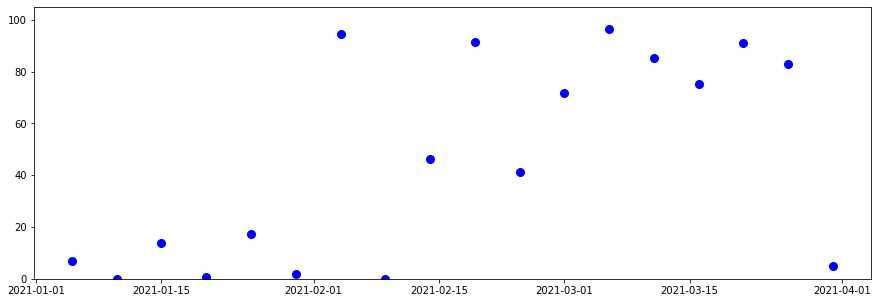

In [11]:
plt.figure(figsize = (15,5))
plt.plot(coverage_table["Date"].values, coverage_table["Clean_percent"].values, 'bo', markersize=8)
plt.ylim([0, 105])
plt.show()

## Review an RGB scene for a selected time slice

In [12]:
# Load the data to create an RGB image
sentinel_dataset = dc.load(latitude = latitude,
                           longitude = longitude,
                           platform = platform,
                           time = time_extents,
                           product = product,
                           group_by='solar_day',
                           measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2']) 

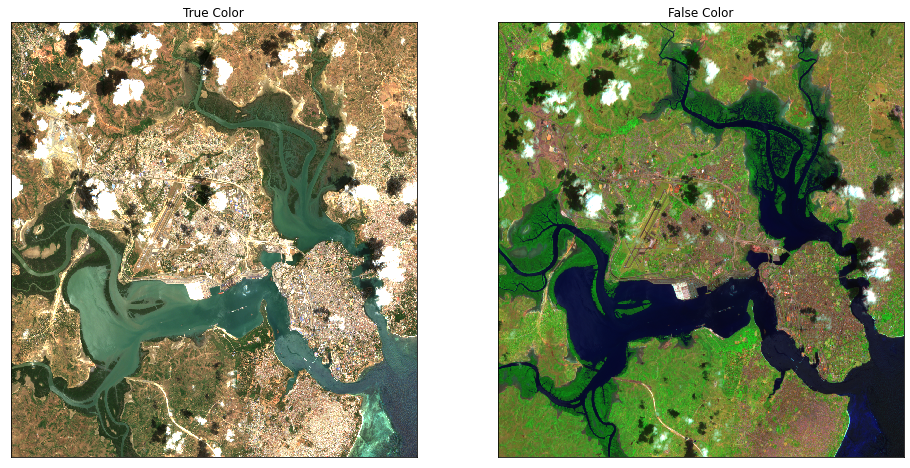

In [13]:
#3 MODIFY HERE

# Select one of the time slices and create an RGB image. 
# Time slices are numbered from 0 to x and shown in the table above
# Review the clean_percentage values above to select scenes with few clouds
# Clouds will be visible in WHITE for an RGB image

# RGB image options
# True-Color RGB = Red, Green, Blue
# False Color RGB (Mosaic) = SWIR2, NIR, Green

slice = 6  

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
true_rgb = sentinel_dataset.isel(time=slice)[['red', 'green', 'blue']].to_array()
false_rgb = sentinel_dataset.isel(time=slice)[['swir2', 'nir', 'green']].to_array()
true_rgb.plot.imshow(ax=ax[0], vmin=0, vmax=2000)
false_rgb.plot.imshow(ax=ax[1], vmin=0, vmax=5000)
ax[0].set_title('True Color'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('False Color'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.show()